# Introduction

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math

# df = pd.read_csv('vehicles.csv', nrows=10000)
df = pd.read_csv('vehicles.csv')
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

# Data Cleaning & Preprocessing

In [2]:
import pandas as pd

# 假设 df 已经读取: df = pd.read_csv('vehicles.csv')

# 1) 先把 posting_date 转成统一的 UTC 时间
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True)

# 2) 丢弃无法解析的行 (NaT)
df.dropna(subset=['posting_date'], inplace=True)

# 3) 去除时区信息 => 得到 naive datetime64[ns]
df['posting_date'] = df['posting_date'].dt.tz_convert(None)

# 4) 此时 dtype 必然是 datetime64[ns]
print("posting_date dtype =>", df['posting_date'].dtype)

# 5) 现在就可以做任何 .dt 操作
df['month'] = df['posting_date'].dt.month
df['dayofweek'] = df['posting_date'].dt.dayofweek

print(df[['posting_date','month','dayofweek']].head())
print("Done! posting_date is now a proper datetime64[ns] column.")


# 1.2 Basic cleaning
# - For demonstration, we do a log transform on price
df = df.dropna(subset=['price', 'posting_date'])
df = df[df['price'] > 0]
df['price_backup'] = df['price']
df['price'] = np.log(df['price'] + 1)
df['posting_date'] = pd.to_datetime(df['posting_date'])

df = df.sort_values(by=['VIN','posting_date']).reset_index(drop=True)
df.fillna(method='ffill', inplace=True)  # or do more sophisticated fill

# 1.3 Some columns are not very useful or too messy (id, url, image_url, description...). 
#    You might drop them or do advanced text processing, here we just drop them:
drop_cols = ['id','url','region_url','image_url','description']
for c in drop_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# numeric_cols we want to put in LSTM as float
numeric_cols = ['price','year','odometer','lat','long','month','dayofweek']

# categorical columns (embedding)
cat_cols = ['region','manufacturer','model','condition','cylinders','fuel',
            'title_status','transmission','VIN','drive','size','type','paint_color',
            'county','state']

# fill missing with 'unknown'
for c in cat_cols:
    df[c] = df[c].fillna('unknown')

# 1.5 Create mapping for each cat_col => cat_id
cat_id_maps = {}
for c in cat_cols:
    unique_vals = df[c].unique().tolist()
    cat_id_maps[c] = {v: i for i,v in enumerate(unique_vals)}
    new_col = c + "_id"
    df[new_col] = df[c].map(cat_id_maps[c])

# Let's define a function to get "cat_id_cols"
cat_id_cols = [c+"_id" for c in cat_cols]


posting_date dtype => datetime64[ns]
          posting_date  month  dayofweek
27 2021-05-04 17:31:18      5          1
28 2021-05-04 17:31:08      5          1
29 2021-05-04 17:31:25      5          1
30 2021-05-04 15:41:31      5          1
31 2021-05-03 19:02:03      5          0
Done! posting_date is now a proper datetime64[ns] column.


/var/folders/lb/2kf_rwj52l35js9f___clr600000gn/T/ipykernel_88738/293229545.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # or do more sophisticated fill


In [3]:
# 1.6 Now we have numeric_cols + cat_id_cols + 'posting_date', 'VIN' etc.
# We'll do a sliding window to create data_sequences

seq_len = 3

data_sequences = []
grouped = df.groupby('VIN', sort=False)
for vin, group in grouped:
    group = group.sort_values('posting_date').reset_index(drop=True)
    if len(group) <= seq_len:
        continue
    
    #  numeric_data => shape [T, len(numeric_cols)]
    numeric_data = group[numeric_cols].values  
    #  cat_data => for each cat col, shape [T], we will store them into a dict
    cat_data_dict = {}
    for c in cat_id_cols:
        cat_data_dict[c] = group[c].values  # shape [T]
    
    # also store date and vin str for later
    date_arr = group['posting_date'].values

    for start_idx in range(len(group) - seq_len):
        end_idx = start_idx + seq_len
        
        # X_seq_numeric => [seq_len, len(numeric_cols)]
        X_seq_numeric = numeric_data[start_idx:end_idx]

        # for each cat, we build X_seq_{cat}, shape [seq_len]
        cat_seq_vals = {}
        for c in cat_id_cols:
            cat_seq_vals[c] = cat_data_dict[c][start_idx:end_idx]

        # y => the next step price (log)
        y_price = numeric_data[end_idx, 0]  # 'price' is the 0th of numeric_cols
        y_date  = date_arr[end_idx]

        # We'll store (X_seq_numeric, cat_seq_vals, y_price, y_date, VIN_str)
        data_sequences.append((X_seq_numeric, cat_seq_vals, y_price, y_date, vin))


print("Total sequences:", len(data_sequences))

Total sequences: 231965


==============

In [4]:
# ============================================================================
# 2. BUILD SOLID DATASET WITH *ALL* FEATURES
# ============================================================================

def build_dataset_for_train(data_list, batch_size=64, shuffle=False):
    """
    Return DS => ( (X_numeric, <each cat_id seq>), y_label )
    """
    X_numeric_list = []
    cat_seq_lists = { c: [] for c in cat_id_cols }  # each is a list
    y_label_list = []

    for (num_seq, cat_dict, y, y_date, vin_str) in data_list:
        X_numeric_list.append(num_seq)
        # cat_dict => { 'region_id': [a,b,c], 'manufacturer_id': [x,y,z], ...}
        for c in cat_id_cols:
            cat_seq_lists[c].append(cat_dict[c])
        y_label_list.append(y)

    X_numeric = np.array(X_numeric_list, dtype=np.float32)  # shape [N, seq_len, len(numeric_cols)]
    
    cat_seq_arrays = {}
    for c in cat_id_cols:
        cat_seq_arrays[c] = np.array(cat_seq_lists[c], dtype=np.int32)  # shape [N, seq_len]
    
    y_label = np.array(y_label_list, dtype=np.float32)
    
    # We'll combine into one big tuple => (X_numeric, cat_seq_arrays..., y_label)
    # But we typically want ( (X_numeric, cat1, cat2, ...), y_label )
    def gen():
        for i in range(len(y_label)):
            # build the "X" for i-th sample
            x_num = X_numeric[i]
            x_cat_list = []
            for c in cat_id_cols:
                x_cat_list.append(cat_seq_arrays[c][i])
            # x_cat_list is a list of shape (seq_len,) arrays => we keep them separate

            # yield ( (x_num, x_cat_list[0], x_cat_list[1], ... ), y_label[i] )
            # but we want them in a stable order
            yield ( ( x_num, *x_cat_list ), y_label[i] )

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=((tf.float32, *([tf.int32]*len(cat_id_cols))), tf.float32),
        output_shapes=(
            (
                tf.TensorShape([seq_len, len(numeric_cols)]),
                *[tf.TensorShape([seq_len]) for _ in cat_id_cols]
            ),
            tf.TensorShape([])
        )
    )
    if shuffle:
        ds = ds.shuffle(len(data_list))
    ds = ds.batch(batch_size)
    return ds


def build_dataset_for_inference(data_list, batch_size=64):
    """
    Return DS => ( (X_numeric, <cat seq>), (y_label, date, vin) )
    So we can do model.predict(...) manually but keep date/vin for analysis
    """
    X_numeric_list = []
    cat_seq_lists = { c: [] for c in cat_id_cols }
    y_label_list = []
    date_list = []
    vin_list = []

    for (num_seq, cat_dict, y, y_date, vin_str) in data_list:
        X_numeric_list.append(num_seq)
        for c in cat_id_cols:
            cat_seq_lists[c].append(cat_dict[c])
        y_label_list.append(y)
        date_list.append(str(y_date))
        vin_list.append(str(vin_str))

    X_numeric = np.array(X_numeric_list, dtype=np.float32)
    cat_seq_arrays = {}
    for c in cat_id_cols:
        cat_seq_arrays[c] = np.array(cat_seq_lists[c], dtype=np.int32)
    y_label = np.array(y_label_list, dtype=np.float32)
    date_arr = np.array(date_list)
    vin_arr = np.array(vin_list)

    def gen():
        for i in range(len(y_label)):
            x_num = X_numeric[i]
            x_cat_list = []
            for c in cat_id_cols:
                x_cat_list.append(cat_seq_arrays[c][i])
            yield ( ( x_num, *x_cat_list ), (y_label[i], date_arr[i], vin_arr[i]) )

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(
            (tf.float32, *([tf.int32]*len(cat_id_cols))),
            (tf.float32, tf.string, tf.string)
        ),
        output_shapes=(
            (
                tf.TensorShape([seq_len, len(numeric_cols)]),
                *[tf.TensorShape([seq_len]) for _ in cat_id_cols]
            ),
            (tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([]))
        )
    ).batch(batch_size)

    return ds

In [5]:
# ============================================================================
# 3. CREATE MODEL: MULTIPLE INPUTS (ONE FOR X_NUMERIC, ONE PER CATEGORICAL)
# ============================================================================

def create_model(
    numeric_dim,   # len(numeric_cols)
    cat_vocab_sizes,  # dict { cat_col: vocab_size }
    embedding_dims,   # dict { cat_col: emb_dim }
    lstm_hidden_size=64,
    learning_rate=1e-3
):
    """
    We'll create 1 input for numeric float features: shape=(seq_len, numeric_dim)
    Then for each cat col, 1 input shape=(seq_len,)
    Then we do Embedding, and concat them all => LSTM => Dense(1).
    """
    # 1) Numeric input
    input_numeric = keras.Input(shape=(None, numeric_dim), dtype=tf.float32, name='num_input')
    # shape=(batch_size, seq_len, numeric_dim)

    # For each cat col, we define an Input
    input_dict = {}
    emb_layers = {}
    cat_inputs = []
    for c in cat_id_cols:
        vocab_size = cat_vocab_sizes[c]
        emb_dim = embedding_dims[c]
        inp = keras.Input(shape=(None,), dtype=tf.int32, name=f"{c}_input")
        input_dict[c] = inp
        # Embedding
        emb_layer = keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, name=f"{c}_emb")
        emb_layers[c] = emb_layer
        cat_inputs.append(inp)

    # 2) Embedding transforms
    cat_embs = []
    for c in cat_id_cols:
        emb = emb_layers[c](input_dict[c])  # shape=(batch, seq_len, emb_dim)
        cat_embs.append(emb)

    # 3) Concat => numeric + all cat embeddings
    concat_seq = keras.layers.Concatenate(axis=-1)([input_numeric, *cat_embs])
    # shape => (batch, seq_len, numeric_dim + sum_of_all_emb_dims)

    # 4) LSTM
    lstm_out = keras.layers.LSTM(lstm_hidden_size, return_sequences=False)(concat_seq)

    # 5) Output
    output_price = keras.layers.Dense(1)(lstm_out)

    # Build final model
    model = keras.Model(
        inputs=[input_numeric, *cat_inputs],
        outputs=output_price
    )
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

In [ ]:
# ============================================================================
# 4. EXAMPLE: SPLIT DATA, TRAIN, INFERENCE
# ============================================================================

# 4.1 Shuffle & split holdout
np.random.shuffle(data_sequences)
holdout_ratio = 0.2
holdout_size = int(len(data_sequences) * holdout_ratio)
test_holdout_data = data_sequences[:holdout_size]
cv_data = data_sequences[holdout_size:]
print(f"Holdout size={holdout_size}, CV size={len(cv_data)}")

# 4.2 Build train DS
train_ds_final = build_dataset_for_train(cv_data, batch_size=64, shuffle=True)
# 4.3 Create model

# figure out cat_vocab_sizes from cat_id_maps
cat_vocab_sizes = {}
for c in cat_id_cols:
    cat_vocab_sizes[c] = len(cat_id_maps[c.replace('_id','')])  # or len(df[c].unique())

# decide embedding_dim for each cat col
embedding_dims = {}
for c in cat_id_cols:
    embedding_dims[c] = 8  # or differ by col

model = create_model(
    numeric_dim=len(numeric_cols),
    cat_vocab_sizes=cat_vocab_sizes,
    embedding_dims=embedding_dims,
    lstm_hidden_size=64,
    learning_rate=1e-3
)

model.summary()

# 4.4 Train
history = model.fit(train_ds_final, epochs=5, verbose=1)

# 4.5 Evaluate on holdout
test_ds_for_eval = build_dataset_for_train(test_holdout_data, batch_size=64, shuffle=False)
mse_test = model.evaluate(test_ds_for_eval, verbose=0)
rmse_test = math.sqrt(mse_test)
print(f"Test MSE={mse_test:.4f}, RMSE={rmse_test:.4f}")

Holdout size=46393, CV size=185572
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ region_id_input     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manufacturer_id_in… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_id_input      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ condition_id_input  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cylinders_id_input  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuel_id_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_status_id_in… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transmission_id_in… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VIN_id_input        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drive_id_input      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_id_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type_id_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ paint_color_id_inp… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ county_id_input     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_id_input      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ region_id_emb       │ (None, None, 8)   │      3,232 │ region_id_input[

 Total params: 1,126,569 (4.30 MB)

 Trainable params: 1,126,569 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2025-03-09 17:37:59.630449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34823 of 185572
2025-03-09 17:38:19.630363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 103606 of 185572
2025-03-09 17:38:39.630267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 172414 of 185572


     43/Unknown 55s 4ms/step - loss: 94.3746

2025-03-09 17:38:43.463800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 16.6967
Epoch 2/5


2025-03-09 17:38:54.569557: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/evelyn/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-09 17:39:04.577029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34099 of 185572
2025-03-09 17:39:24.576988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 102314 of 185572
2025-03-09 17:39:44.576962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDat

  45/2900 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.9432  

2025-03-09 17:39:49.016159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - loss: 1.7424
Epoch 3/5


2025-03-09 17:39:59.056484: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-09 17:40:09.059905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34066 of 185572
2025-03-09 17:40:29.059727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 102186 of 185572
2025-03-09 17:40:39.059951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 136115 of 185572
2025-03-09 17:40:49.059946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 169815 of 185572
2025-03-09 17:40:59.064692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuf

  24/2900 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 1.8117  

2025-03-09 17:41:06.367377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 1.7516
Epoch 4/5


2025-03-09 17:41:27.938386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33927 of 185572
2025-03-09 17:41:47.938357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 101330 of 185572
2025-03-09 17:42:07.938382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168282 of 185572


  42/2900 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.2194 

2025-03-09 17:42:13.196251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - loss: 1.7823
Epoch 5/5


2025-03-09 17:42:23.390905: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-09 17:42:33.394395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34125 of 185572
2025-03-09 17:42:43.394444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 67797 of 185572
2025-03-09 17:42:53.394490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 101436 of 185572
2025-03-09 17:43:13.394506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168950 of 185572


  46/2900 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.5638   

2025-03-09 17:43:18.368893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - loss: 1.7494
Test MSE=1.7471, RMSE=1.3218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

TypeError: <class 'bytes'> is not convertible to datetime, at position 0

                     VIN                date        y_true        y_pred
27661  00000000000000000 2021-04-18 19:12:33  4.500002e+04  11172.205263
44508  00000000000000000 2021-05-04 15:31:57  1.234569e+07  11172.205263
10640  00000HDJ810018347 2021-05-03 23:55:29  3.959899e+04  11172.205263
40403  00000HDJ810018347 2021-05-03 23:56:19  3.959899e+04  11172.205263
45084  00000HDJ810018347 2021-05-03 23:58:23  3.959899e+04  11172.205263
3016   00000HDJ810018347 2021-05-04 00:00:34  3.959899e+04  11172.205263
8343   0000464CK56172438 2021-04-16 22:15:43  2.845000e+04  11172.205263
44617  0000464CK56172438 2021-04-17 00:00:33  2.845000e+04  11172.205263
19805        0R07C118059 2021-05-03 22:50:33  2.499501e+04  11172.205263
29745       107044120551 2021-04-28 20:07:53  2.790000e+04  11172.205263


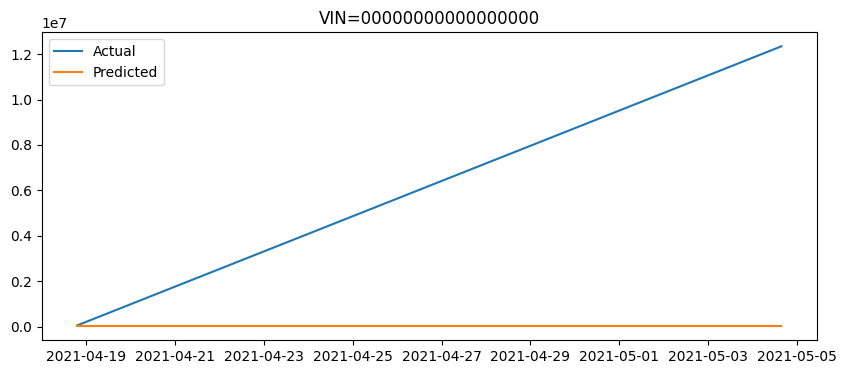

In [ ]:
# ============================================================================
# 5. INFERENCE & VISUALIZATION
# ============================================================================
test_ds_for_infer = build_dataset_for_inference(test_holdout_data, batch_size=64)

y_preds_log = []
y_trues_log = []
dates_list = []
vins_list  = []

for X_batch, Y_info_batch in test_ds_for_infer:
    # X_batch => ( input_numeric, cat1, cat2, ... )
    # Y_info_batch => (y_label, date, vin)
    y_batch, date_batch, vin_batch = Y_info_batch

    preds = model.predict(X_batch)
    y_preds_log.extend(preds.ravel().tolist())
    y_trues_log.extend(y_batch.numpy().tolist())
    dates_list.extend(date_batch.numpy().tolist())
    vins_list.extend(vin_batch.numpy().tolist())

# if we had log(price+1)
y_preds = np.exp(y_preds_log) - 1
y_trues = np.exp(y_trues_log) - 1

df_pred = pd.DataFrame({
    'VIN': [v.decode('utf-8') if isinstance(v, bytes) else v for v in vins_list],
    'date': [
        pd.to_datetime(d.decode('utf-8')) if isinstance(d, bytes) else pd.to_datetime(d)
        for d in dates_list
    ],
    'y_true': y_trues,
    'y_pred': y_preds
})
df_pred.sort_values(['VIN','date'], inplace=True)

# Quick check
print(df_pred.head(10))


# Optionally pick one VIN to plot
sample_vin = df_pred['VIN'].iloc[0]
tmp = df_pred[df_pred['VIN'] == sample_vin].copy()
plt.figure(figsize=(10,4))
plt.plot(tmp['date'], tmp['y_true'], label='Actual')
plt.plot(tmp['date'], tmp['y_pred'], label='Predicted')
plt.title(f"VIN={sample_vin}")
plt.legend()
plt.show()

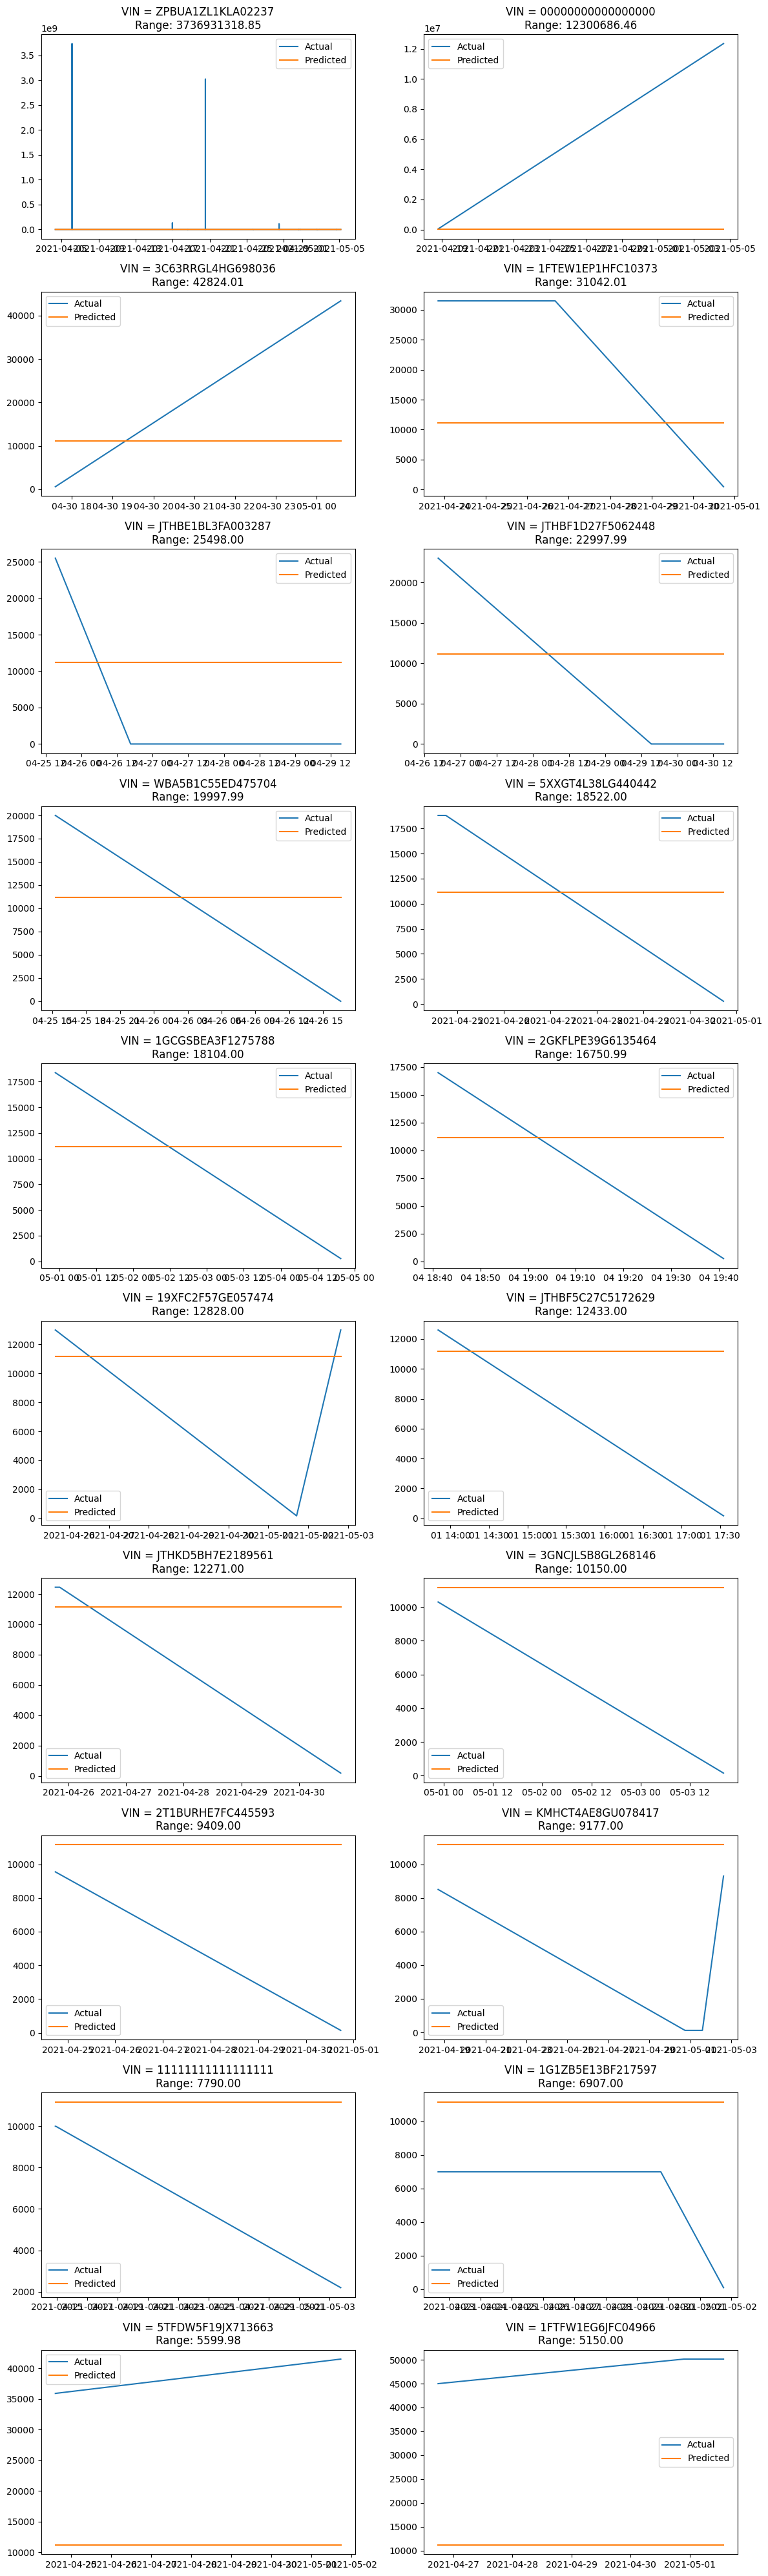

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# 假设您已经有 df_pred，包含列: ['VIN', 'date', 'y_true', 'y_pred']
# 其中 y_true, y_pred 是原始价格（若之前做过 log(price+1)，请记得已做还原 exp(...) - 1）

# 1) 按 VIN 分组，计算 "波动幅度" = max(y_true) - min(y_true)
vin_ranges = []
grouped = df_pred.groupby('VIN')
for vin, group in grouped:
    price_range = group['y_true'].max() - group['y_true'].min()
    vin_ranges.append((vin, price_range))

# 2) 按波动幅度从大到小排序
vin_ranges.sort(key=lambda x: x[1], reverse=True)

# 3) 选择前 N 个 (比如 5 个) 价格波动最大的 VIN
top_n = 20
# selected_vins = [x[0] for x in vin_ranges[:top_n]]

# Sort ascending by price range (smallest first)
# vin_ranges.sort(key=lambda x: x[1])

# Select the top 20 VINs with the smallest fluctuation
top_n = 20
selected_vins = [x[0] for x in vin_ranges[:top_n]]


# 4) 画图: 每个 VIN 都做一张小图(subplot)
num_vins = len(selected_vins)
cols = 2  # 每行放2张图
rows = math.ceil(num_vins / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
# 如果只有1行1列，axes 可能不是数组，这里统一 flatten 处理
axes = axes.flatten() if num_vins > 1 else [axes]

for i, vin_id in enumerate(selected_vins):
    ax = axes[i]
    
    # 提取该 VIN 的数据
    tmp = df_pred[df_pred['VIN'] == vin_id].copy()
    tmp.sort_values('date', inplace=True)
    
    # 绘制真实价 vs. 预测价
    ax.plot(tmp['date'], tmp['y_true'], label='Actual')
    ax.plot(tmp['date'], tmp['y_pred'], label='Predicted')
    
    # 标题上可加上“波动区间”辅助信息
    vin_range = vin_ranges[i][1]
    ax.set_title(f"VIN = {vin_id}\nRange: {vin_range:.2f}")
    ax.legend()

# 如果选的 top_n < rows*cols，会有多余 subplot，这里可以隐藏掉
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

def build_Xy_for_linear(data_list, seq_len=3):
    """
    data_list 每个元素: (X_seq_numeric, X_seq_vin, X_seq_bm, y_price, y_date, vin_str)
    X_seq_numeric shape = [seq_len, num_numeric_features]
    扁平化 X_seq_numeric => [seq_len * num_numeric_features]
    返回: X, y
    """
    X_list = []
    y_list = []
    for (num_seq, vin_seq, bm_seq, y, y_date, vin_str) in data_list:
        # num_seq shape => (seq_len, num_numeric_features)
        # flatten:
        x_flat = num_seq.flatten()  # shape (seq_len * num_numeric_features,)
        
        X_list.append(x_flat)
        y_list.append(y)
    
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y


# Trainning & Fitting Machine Learning Models

## 1. Linear Regression Model: Ridge Regression

### Rationale of Selection

- Ridge Regression adds an L2 penalty to the loss function. This shrinks coefficients but generally keeps all features in the model.
- Lasso (L1 penalty) tends to zero out coefficients of less important features, effectively performing feature selection. This can be useful in some scenarios, but it can also drop too many correlated features and become unstable if you want to leverage those correlations.
- In real-world used-car datasets, you may have correlated features (e.g., year and odometer, or manufacturer and model). Ridge handles multicollinearity more gracefully—rather than arbitrarily zeroing out correlated features, it shrinks them equally. This usually yields more stable results.
- Elastic Net (a mix of L1 and L2) is also a possibility, but if you don’t specifically need feature selection from Lasso, Ridge is a solid, simpler choice

### Strengths
- Very fast to train on large tabular data.
- Interpretability: You can easily examine which features have higher coefficients.
- Good baseline to quickly gauge your data’s linear separability.

### Weaknesses
- Struggles with non-linear relationships unless you manually engineer polynomial or interaction terms.
- May still underfit if the real relationship between features and price is complex.

## 2. Tree-Based Model: Random Forest Regressor

### Rationale of Selection
- Random Forest is an ensemble of many decision trees, each trained on different subsets of the data (rows and/or columns).
- It naturally captures non-linearities and feature interactions without extensive feature engineering.
- It is fairly robust to outliers and can handle missing values (with proper strategy or imputation).
- Typically achieves strong performance on tabular data.

### Strengths
- High predictive power and often outperforms simple linear models.
- Inherent feature importance assessment, which helps with interpretability.
- Averaging across multiple trees reduces overfitting compared to a single decision tree.

### Weaknesses
- Can be memory-intensive if a large number of trees is used.
- Predictions can be slower due to the need to average many decision trees.
- Less straightforward to interpret compared to a pure linear model (though feature importances can mitigate that).

## 3. Neural Network Model: Multilayer Perceptron (MLP)

### Rationale of Selection
- A feedforward MLP is generally the best neural network choice for tabular data (as opposed to CNNs for image data or LSTMs for sequence data).
- Can capture complex non-linear relationships if given enough layers/neurons.
- Offers flexibility with different architectures, regularization schemes (dropout, batch normalization), and activation functions.

### Strengths
- Highly flexible universal approximator; can learn intricate patterns in the data.
- Scales well with more data, potentially outperforming simpler models given sufficient examples.
- Possible to use embedding layers for high-cardinality categorical features, reducing dimensionality.

### Weaknesses
- Tuning hyperparameters (number of layers, neurons, learning rate, etc.) can be complex and time-consuming.
- More prone to overfitting if not properly regularized.
- Less interpretable compared to linear or tree-based models.

In [ ]:
num_unique_vin = df_cleaned['VIN'].nunique(dropna=True)
print("number of unique vin", num_unique_vin)

num_unique_id = df_cleaned['id'].nunique(dropna=True)
print("number of unique id", num_unique_id)

## 4. Nearest Neighbor Model: K-Nearest Neighbors (KNN) Regressor

### Rationale of Selection
- **KNN Regressor** predicts a target value based on the average (or another aggregation) of the k nearest neighbors in feature space.
- No explicit “training” phase—KNN stores the entire dataset and performs distance-based lookups during prediction.
- Can handle complex boundaries since the decision (or prediction) is based purely on local neighbor information.

### Strengths
- Simple to implement and understand conceptually.
- Naturally captures non-linear relationships if the data in the local neighborhood is consistent.
- Few parameters: mainly k (number of neighbors) and distance metric (e.g., Euclidean).

### Weaknesses
- Can be **slow at prediction time** for large datasets because it must search through all or a large portion of the data.
- **Sensitive to feature scaling**—proper normalization/standardization is crucial.
- Choosing the optimal number of neighbors (k) can be non-trivial and must be tuned with techniques like cross-validation.